In [1]:
import sys
print(sys.version)

import sklearn.ensemble
import shap
import numpy as np
import numba
import time
import json
import xgboost
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import shap.benchmark

from shap import TreeExplainer as TreeCext

from shap.explainers.pytree import *

3.10.6 (main, Nov 14 2022, 16:10:14) [GCC 11.3.0]


/home/jarek/projects/shap/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
np.set_printoptions(threshold=sys.maxsize)
# X,y = shap.datasets.communitiesandcrime()
X,y = shap.datasets.boston()
print(X.columns.values.tolist())
print(len(X.columns.values.tolist()))

print(X.shape)
print(y.shape)

['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
13
(506, 13)
(506,)


In [ ]:
# X,y = shap.datasets.boston()
# X = X.values
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# model = sklearn.ensemble.RandomForestRegressor(n_estimators=1000, max_depth=13)
# model.fit(X_train, y_train)

# TreeBanzCext = shap.explainers.Tree(model, use_banz=True, change_deltas=True)
# TreeBanzCext(X_test)

1
# ex = TreeExplainer(model)
# res_banz_py = ex.banz_values(X_test)


In [4]:
# Zobaczmy na tym datasecie jaka glebokosc daje najlepsze wyszkolenie

X,y = shap.datasets.boston()
X = X.values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

scores = {}
mean = 5

for i in range(1,13):
    pass
    print(i)
    scores[i] = 0
    for j in range(mean):
        model = sklearn.ensemble.RandomForestRegressor(n_estimators=1000, max_depth=i)
        model.fit(X_train, y_train)
        scores[i] = scores[i] + model.score(X_test, y_test)
    scores[i] = scores[i] / mean

scores

1
2
3
4
5
6
7
8
9
10
11
12


{1: 0.5016155664468874,
 2: 0.6638759158881746,
 3: 0.7526557692818062,
 4: 0.7739813296400534,
 5: 0.78292703385011,
 6: 0.7894470225634531,
 7: 0.7949634608800304,
 8: 0.7950348097942115,
 9: 0.7984405326508621,
 10: 0.7981029904341271,
 11: 0.7981121859763812,
 12: 0.8007580331481264}

In [5]:
def item_generator(json_input, lookup_key):
    if isinstance(json_input, dict):
        for k, v in json_input.items():
            if k == lookup_key:
                yield v
            else:
                yield from item_generator(v, lookup_key)
    elif isinstance(json_input, list):
        for item in json_input:
            yield from item_generator(item, lookup_key)

def tree_depth(json_text):
    json_input = json.loads(json_text)
    return max(list(item_generator(json_input, 'depth'))) + 1


In [69]:
import shap.datasets as ds

def a(x):
    X, y = x
    print(X.shape)

a(ds.adult())
a(ds.boston())
a(ds.communitiesandcrime())
a(ds.corrgroups60())
a(ds.diabetes())
a(ds.imagenet50())
# a(ds.imdb())
a(ds.independentlinear60())
a(ds.iris())
a(ds.nhanesi())

(32561, 12)
(506, 13)
(1994, 101)
(1000, 60)
(442, 10)
(50, 224, 224, 3)
(1000, 60)
(150, 4)
(14264, 79)


In [95]:
# Zobaczmy na tym datasecie jaka glebokosc daje najlepsze wyszkolenie

X,y = shap.datasets.nhanesi()
X = X.values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, test_size=0.2)

xgb_full = xgboost.DMatrix(X, label=y)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

scores = {}
mean_depths = {}
stddev_depths = {}
full_depths = {}

mean = 10

for i in range(1):
    print(i)
    scores[i] = 0
    mean_depths[i] = 0
    stddev_depths[i] = 0
    for j in range(mean):
        params = {
            "eta": 0.002,
            "max_depth": 3,
            "objective": "survival:cox",
            "subsample": 0.5
        }
#         model = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)
        model = xgboost.XGBRegressor(n_estimators=1000, max_depth=18, subsample=0.3)
#         X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
        scores[i] = scores[i] + model.score(X_test, y_test)
        
        booster = model.get_booster()
        tree_df = booster.trees_to_dataframe()
#         print("rysuje drzewo")
#         xgboost.plotting.plot_tree(booster)
        depths = [tree_depth(x) for x in booster.get_dump(dump_format = "json")]
        full_depths[i] = depths
        mean_depths[i] = mean_depths[i] + np.mean(depths)
        stddev_depths[i] = stddev_depths[i] + np.std(depths)
        
    scores[i] = scores[i] / mean
    mean_depths[i] = mean_depths[i] / mean
    stddev_depths[i] = stddev_depths[i] / mean

print(scores)
# print(mean_depths)
# print(stddev_depths)

0


ValueError: max() arg is an empty sequence

In [ ]:
# narysujmy sobie zaleznosc wytrenowania i glebokosci
sns.set()
n = max(scores)
to_plot_scores = [0] * n
to_plot_mean = [0] * n
to_plot_stddev = [0] * n

for i in scores.keys():
    to_plot_scores[i-1] = scores[i]
    to_plot_mean[i-1] = mean_depths[i]
    to_plot_stddev[i-1] = stddev_depths[i]

plt.title("Average score of models")
plt.ylabel("Accuracy in %")
plt.xlabel("Max tree depth")
plt.plot(to_plot_scores)
plt.show()
    
# ax = sns.heatmap(quality)
# plt.show()
# print(to_plot_mean)
# print(to_plot_stddev)

plt.title("Mean depth of tree in ensemble")
plt.ylabel("Mean depth")
plt.xlabel("Max tree depth")
plt.errorbar(range(len(to_plot_mean)), to_plot_mean, to_plot_stddev, linestyle='None', marker='^')
plt.show()

In [78]:
scores = {}
mean_depths = {}
stddev_depths = {}
full_depths = {}

mean = 10

for i in range(1,32):
    print(i)
    scores[i] = 0
    mean_depths[i] = 0
    stddev_depths[i] = 0
    for j in range(mean):
        model = xgboost.XGBRegressor(n_estimators=(100+i*100), max_depth=16, subsample=0.3)
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)
        scores[i] = scores[i] + model.score(X_test, y_test)
        
        booster = model.get_booster()
        tree_df = booster.trees_to_dataframe()
#         print("rysuje drzewo")
#         xgboost.plotting.plot_tree(booster)
        depths = [tree_depth(x) for x in booster.get_dump(dump_format = "json")]
        full_depths[i] = depths
        mean_depths[i] = mean_depths[i] + np.mean(depths)
        stddev_depths[i] = stddev_depths[i] + np.std(depths)
        
    scores[i] = scores[i] / mean
    mean_depths[i] = mean_depths[i] / mean
    stddev_depths[i] = stddev_depths[i] / mean

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [79]:
print(scores)

{1: 0.2366671726607938, 2: 0.2366671726607938, 3: 0.2366671726607938, 4: 0.2366671726607938, 5: 0.2366671726607938, 6: 0.2366671726607938, 7: 0.2366671726607938, 8: 0.2366671726607938, 9: 0.2366671726607938, 10: 0.2366671726607938, 11: 0.2366671726607938, 12: 0.2366671726607938, 13: 0.2366671726607938, 14: 0.2366671726607938, 15: 0.2366671726607938, 16: 0.2366671726607938, 17: 0.2366671726607938, 18: 0.2366671726607938, 19: 0.2366671726607938, 20: 0.2366671726607938, 21: 0.2366671726607938, 22: 0.2366671726607938, 23: 0.2366671726607938, 24: 0.2366671726607938, 25: 0.2366671726607938, 26: 0.2366671726607938, 27: 0.2366671726607938, 28: 0.2366671726607938, 29: 0.2366671726607938, 30: 0.2366671726607938, 31: 0.2366671726607938}


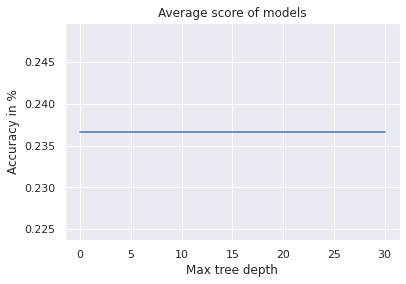

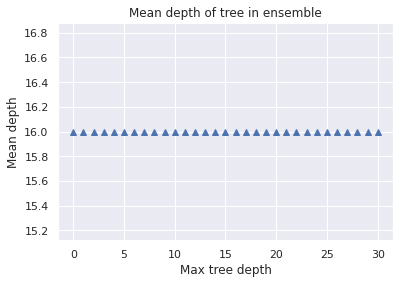

In [80]:
# narysujmy sobie zaleznosc wytrenowania i glebokosci w XGBoost
sns.set()
n = len(scores)
to_plot_scores = [0] * n
to_plot_mean = [0] * n
to_plot_stddev = [0] * n

for i in scores.keys():
    to_plot_scores[i-1] = scores[i]
    to_plot_mean[i-1] = mean_depths[i]
    to_plot_stddev[i-1] = stddev_depths[i]

plt.title("Average score of models")
plt.ylabel("Accuracy in %")
plt.xlabel("Max tree depth")
plt.plot(to_plot_scores)
plt.show()
    
# ax = sns.heatmap(quality)
# plt.show()
# print(to_plot_mean)
# print(to_plot_stddev)

plt.title("Mean depth of tree in ensemble")
plt.ylabel("Mean depth")
plt.xlabel("Max tree depth")
plt.errorbar(range(len(to_plot_mean)), to_plot_mean, to_plot_stddev, linestyle='None', marker='^')
plt.show()

In [83]:
print(X)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [81]:
res_shap_cext = {}
res_banz_cext = {}

time_shap_cext = {}
time_banz_cext = {}

for j in range (2,26,2):

    for i in range(100, 1000, 100):
        model = sklearn.ensemble.RandomForestRegressor(n_estimators=i, max_depth=j)
        model.fit(X, y)
        
        print("------------------------------")
        print(j, i)
        print("---")
        
        start = time.time()
        res_shap_cext[(i, j)] = TreeCext(model).shap_values(X, banz=False)
        time_shap_cext[(i, j)] = time.time() - start
        print(time_shap_cext[(i, j)])

        start = time.time()
        res_banz_cext[(i, j)] = TreeCext(model).shap_values(X, banz=True)
        time_banz_cext[(i, j)] = time.time() - start
        print(time_banz_cext[(i, j)])

ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
time_shap_cext_prop = [ [time_shap_cext[(i, j)] for j in range (2,26,2)] for i in range(100, 1000, 100)]
time_banz_cext_prop = [ [time_banz_cext[(i, j)] for j in range (2,26,2)] for i in range(100
                                                                                        , 1000, 100)]

In [ ]:
time_diffs_banz_shap = \
    [ [ (time_shap_cext[(i, j)] - time_banz_cext[(i, j)]) / time_shap_cext[(i, j)] * 100 \
       for j in range (2,26,2)] for i in range(100, 1000, 100) ]

In [ ]:
plt.figure(figsize=(12, 9))
sns.heatmap(time_diffs_banz_shap, annot=True, fmt=".1f", linewidth=.5,\
           xticklabels=range(2,26,2), yticklabels=range(100, 1000, 100))
plt.title("Percentage of time improvement for TreeShap vs BANZ")
plt.ylabel("No. of trees")
plt.xlabel("Max tree depth")
plt.show()

In [ ]:
res_shap_cext_prop = [res_shap_cext[(i, 0)] for i in range(100, 1000, 100)]
res_banz_cext_prop = [res_banz_cext[(i, 0)] for i in range(100, 1000, 100)]
time_shap_cext_prop = [time_shap_cext[(i, 0)] for i in range(100, 1000, 100)]
time_banz_cext_prop = [time_banz_cext[(i, 0)] for i in range(100, 1000, 100)]

array([[ 1.37503770e-01, -8.66319724e-04,  1.27872692e-01,
        -6.74968835e-03, -2.09104634e-01, -1.48691455e+00,
        -3.91352258e-02, -8.08356114e-02, -1.55221226e-01,
        -2.28603060e-01,  3.82230728e-01,  6.98756359e-03,
         4.43607717e+00],
       [ 2.09370281e-01,  5.83286355e-03, -7.21105859e-02,
        -6.60660071e-03,  3.71994940e-01, -2.11377649e+00,
        -3.04677678e-01, -2.50663661e-01, -1.01492079e-01,
         1.21985876e-01,  1.45796021e-01,  2.72943577e-03,
         1.37690859e+00],
       [ 2.31846513e-01,  1.47688623e-02, -8.79987749e-02,
        -3.07997671e-04,  3.90252051e-01,  5.94829030e+00,
         6.92764884e-02, -1.50574909e-01, -1.09378131e-01,
         3.59219339e-01,  1.00216013e-01,  2.00191007e-02,
         5.22398775e+00],
       [ 2.30973331e-01,  2.33509404e-02,  1.21803974e-01,
        -1.91166864e-03,  3.82495380e-01,  4.72166883e+00,
         1.88514012e-01, -3.50200915e-01,  1.99870939e-02,
         7.25469756e-01, -1.44021781e

array([ 1.37503770e-01, -8.66319724e-04,  1.27872692e-01, -6.74968835e-03,
       -2.09104634e-01, -1.48691455e+00, -3.91352258e-02, -8.08356114e-02,
       -1.55221226e-01, -2.28603060e-01,  3.82230728e-01,  6.98756359e-03,
        4.43607717e+00])

In [ ]:
model = xgboost.XGBRegressor(n_estimators=1000, max_depth=5, subsample=0.3)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)

booster = model.get_booster()
tree_df = booster.trees_to_dataframe()

In [ ]:
tree_df

In [ ]:
plt.plot([x * 10 for x in scores.values()])
plt.plot(mean_depths.values())
plt.plot(stddev_depths.values())

plt.show()

# wychodza glebokosci po 13 jak da mu sie wolna reke

In [ ]:
def run_explain(name, explainer, data):
    start = time.time()
    values = explainer(data)
    end = time.time()
    print("name: {}, time: {}".format(name, end - start))
    return [name, values, end - start]

In [ ]:
def run_diff_explainers(model, X_train, X_eval):
    attributions = {}


    # use an independent masker
    masker = shap.maskers.Independent(X_train)
    pmasker = shap.maskers.Partition(X_train)

    explainers = [
        ("Tree", shap.explainers.Tree(model)),
        ("TreeBanz", shap.explainers.Tree(model,  use_banz=True)),
        ("NEW TreeBanz", shap.explainers.Tree(model,  use_banz=True, change_deltas=True)),
    #     ("Tree approx.", shap.explainers.Tree(model, masker, approximate=True)),
    #     ("Exact", shap.explainers.Exact(model.predict, masker)),
    ]

    attributions[1000] = [run_explain(name, exp, X_eval) for name, exp in explainers]
    
    return attributions

In [ ]:
def show_results(attributions):
    a = attributions[1000]
    # print(a[0][1])


#     plt.stackplot(range(len(a[0][1].values[0])), a[0][1].values[0], a[1][1].values[0], a[2][1].values[0],
#                  labels=["Tree", "TreeBanz", "NEW TreeBanz"])
    
    plt.plot(range(len(a[0][1].values[0])), a[0][1].values[0])
    plt.plot(range(len(a[0][1].values[0])), a[1][1].values[0])
    plt.plot(range(len(a[0][1].values[0])), a[2][1].values[0])
    
    plt.legend()
    # plt.subplot(a)
    plt.show()

    shap.plots.bar(a[0][1][0]) #tree
    shap.plots.bar(a[1][1][0]) #treeBanz
    shap.plots.bar(a[2][1][0]) #NEWtreeBanz

In [ ]:
X,y = shap.datasets.boston()
X = X.values

model = xgboost.XGBRegressor(n_estimators=1000, max_depth=32, subsample=0.3)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)
X_eval = X_test[:1]

attributions = run_diff_explainers(model, X_train, X_eval)

show_results(attributions)

In [ ]:
X,y = shap.datasets.boston()
X = X.values

model = sklearn.ensemble.RandomForestRegressor(n_estimators=1000, max_depth=14)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
model.fit(X_train, y_train)
X_eval = X_test[:1]

attributions = run_diff_explainers(model, X_train, X_eval)

show_results(attributions)

In [ ]:
v = {}
for i in range(3):
    v[i] = [(x / attributions[1000][i][1].values[0][0]) for x in attributions[1000][i][1].values[0]]

v

In [ ]:
shap.plots.beeswarm(a[0][1])
shap.plots.beeswarm(a[1][1])

In [ ]:
# # dry run to get all the code warmed up for valid runtime measurements
# for name, exp in explainers:
#     exp(X_eval[:1])

# explain with all the explainers
attributions = [run_explain(name, exp, X_eval) for name, exp in explainers]

In [ ]:
X, y = make_regression(n_samples=400, n_features=16, n_informative=8,random_state=0, shuffle=False)

model = sklearn.ensemble.RandomForestRegressor(n_estimators=1000, max_depth=10)
model.fit(X, y)

In [ ]:
# bst = xgboost.train({"learning_rate": 0.01, "max_depth": 4}, xgboost.DMatrix(X, label=y), 1000)

In [ ]:
# start = time.time()
# shap_values = bst.predict(xgboost.DMatrix(X), pred_contribs=True)
# print(time.time() - start)


In [ ]:

# x = X.head()
# x = X[:1]
x = X
x

In [ ]:
start = time.time()
res_shap_cext = TreeCext(model).shap_values(X, banz=False)
time_shap_cext = time.time() - start
time_shap_cext

In [ ]:
start = time.time()
res_banz_cext = TreeCext(model).shap_values(X, banz=True)
time_banz_cext = time.time() - start
time_banz_cext

In [ ]:
res_shap_cext

In [ ]:
res_banz_cext

In [ ]:
ex = TreeExplainer(model)
start = time.time()
res_shap_py = ex.shap_values(x)
time_shap_py = time.time() - start

In [ ]:
start = time.time()
res_banz_py = ex.banz_values(x)
time_banz_py = time.time() - start

In [ ]:
line = np.asarray(x[:1])
ex.brute_banz(line[0], 0)

In [ ]:
ex.brute_shap(line[0], 0)

In [ ]:
results_dict_cext = {}
results_dict_cext['banz'] = {}
results_dict_cext['shap'] = {}

In [ ]:
for i in range(1, 10):
    X, y = make_regression(n_samples=200 * i, n_features=16, n_informative=8,random_state=0, shuffle=False)

    model = sklearn.ensemble.RandomForestRegressor(n_estimators=1000 + 100 * i, max_depth=10 + i)
    model.fit(X, y)
    
    start = time.time()
    res_shap_cext = TreeCext(model).shap_values(x, banz=False)
    res_shap = time.time() - start
    
    start = time.time()
    res_banz_cext = TreeCext(model).shap_values(x, banz=True)
    res_banz = time.time() - start
    
    print(res_shap)
    print(res_banz)
    results_dict_cext['banz'][i] = res_banz
    results_dict_cext['shap'][i] = res_shap
    

In [ ]:
x = [i for i in results_dict_cext['banz']]
a1 = [results_dict_cext['banz'][i] for i in results_dict_cext['banz']]
a2 = [results_dict_cext['shap'][i] for i in results_dict_cext['shap']]

y_values = {"banz": a1, "treeshap": a2}
labels = ["BANZ", "TREESHAP"]

fig, ax = plt.subplots()
ax.stackplot(x, y_values.values(), labels=labels)

ax.legend(loc='upper left')
plt.show()

In [ ]:
results_dict_py = {}
results_dict_py['banz'] = {}
results_dict_py['shap'] = {}

In [ ]:
for i in range(1, 10):
    X, y = make_regression(n_samples=100 + 25 * i, n_features=6, n_informative=2,random_state=0, shuffle=False)

    model = sklearn.ensemble.RandomForestRegressor(n_estimators=100 + 25 * i, max_depth=4)
    model.fit(X, y)
    
    ex = TreeExplainer(model)
    print('created model')
    start = time.time()
    res_shap_py = ex.shap_values(X)
    time_shap_py = time.time() - start
    
    start = time.time()
    res_banz_py = ex.banz_values(X)
    time_banz_py = time.time() - start
    
    print(res_shap_py)
    print(res_banz_py)
    results_dict_py['banz'][i] = time_banz_py
    results_dict_py['shap'][i] = time_shap_py
    

In [ ]:
x = [i for i in results_dict_py['banz']]
a1 = [results_dict_py['banz'][i] for i in results_dict_py['banz']]
a2 = [results_dict_py['shap'][i] for i in results_dict_py['shap']]

y_values = {"banz": a1, "treeshap": a2}
labels = ["BANZ", "TREESHAP"]

fig, ax = plt.subplots()
ax.stackplot(x, y_values.values(), labels=labels)

ax.legend(loc='upper left')
plt.show()

In [ ]:
len(a1)

In [ ]:
len(a2)